In [14]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
!pip install scikit-gstat
import skgstat as skg
from skgstat import Variogram, OrdinaryKriging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

  Using cached scikit_gstat-1.0.1-py3-none-any.whl


In [2]:
!pip install metloom

  Using cached metloom-0.2.7-py2.py3-none-any.whl (26 kB)
  Using cached zeep-4.1.0-py2.py3-none-any.whl (100 kB)
  Using cached requests_file-1.5.1-py2.py3-none-any.whl (3.7 kB)
  Using cached platformdirs-2.5.2-py3-none-any.whl (14 kB)
  Using cached requests_toolbelt-0.9.1-py2.py3-none-any.whl (54 kB)
  Using cached lxml-4.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (6.9 MB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)


In [3]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

In [4]:
from snowexsql.data import PointData, ImageData

In [5]:
from metloom.pointdata import SnotelPointData
import geopandas as gpd

In [6]:
# import necessary libraries
from snowexsql.data import SiteData, ImageData
from snowexsql.conversions import raster_to_rasterio, query_to_geopandas
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import from_shape,to_shape
from rasterio.plot import show
from sqlalchemy.sql import func

In [7]:
 def get_aso_depths(dt, snotel_code="622:CO:SNTL", crs=26912, buffer_dist=1000):
    """
    Args:
        dt: datetime or date object
        snotel_code: desired NRCS api station code
        crs: integer crs
        buffer_dist: buffer distance in same units as crs (default 1000 m)
    """
    # Pull in Snotel point 
    sntl_point = SnotelPointData(snotel_code, "dummy name")
    geom = sntl_point.metadata
    geom = gpd.GeoSeries(geom).set_crs(4326).to_crs(crs).geometry.values[0]

    # grab a session
    engine, session = get_db(db_name)

    # Building a buffer which will give us a buffer object around our point
    buffer = session.query(gfunc.ST_SetSRID(gfunc.ST_Buffer(from_shape(geom), buffer_dist), crs)).all()[0][0]

    # Convert to a shapely shapefile object
    circle = to_shape(buffer)

    # Convert to a geopandas dataframe
    df_circle = gpd.GeoSeries(circle)

    # Grab the rasters, union them and convert them as tiff when done
    q = session.query(func.ST_AsTiff(func.ST_Union(ImageData.raster, type_=Raster)))

    # Only grab rasters that are the bare earth DEM from USGS
    q = q.filter(ImageData.type == 'depth').filter(ImageData.observers=='ASO Inc.')
    q = q.filter(ImageData.date == dt)

    # And grab rasters touching the circle
    q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffer))

    # Execute the query
    rasters = q.all()

    # Get the rasterio object of the raster
    dataset = raster_to_rasterio(session, rasters)[0]
    return dataset
    

# get the dataset of 
dataset = get_aso_depths(date(2020, 2, 2))

/tmp/ipykernel_178/2079924611.py:18: SAWarning: Class ST_SetSRID will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  buffer = session.query(gfunc.ST_SetSRID(gfunc.ST_Buffer(from_shape(geom), buffer_dist), crs)).all()[0][0]
/tmp/ipykernel_178/2079924611.py:37: SAWarning: Class ST_Union will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if 

In [8]:
import numpy as np

def rasterio_to_df(dataset):
    data = dataset.read(1)
    data[data < 0 ] = np.nan
    data_shape = data.shape
    crs = dataset.crs
    cols, rows = np.meshgrid(np.arange(data_shape[0]), np.arange(data_shape[1]))
    xs, ys = rasterio.transform.xy(dataset.transform, rows, cols)

    xs = np.array([np.array(xi) for xi in xs])
    ys = np.array([np.array(yi) for yi in ys])
    values = data.flatten()
    points = gpd.points_from_xy(xs.flatten(), ys.flatten())
    df_depths = gpd.GeoDataFrame(geometry=points)
    df_depths["depth"] = values
    df_depths = df_depths.set_crs(crs)
    df_depths = df_depths.dropna()
    return df_depths

In [9]:
# convert the first band of the rasterio dataset to a geodataframe
df_depths = rasterio_to_df(dataset)
# convert crs
df_depths = df_depths.to_crs(4326)
df_depths.head()

,geometry,depth
361725,POINT (-108.06050 39.06066),0.400264
361726,POINT (-108.06046 39.06066),0.000000
361727,POINT (-108.06043 39.06066),0.000000
362489,POINT (-108.03404 39.05999),0.894893
362490,POINT (-108.03401 39.05999),0.904170


In [10]:
from datetime import datetime
sntl_point = SnotelPointData("622:CO:SNTL", "dummy name")
station_data = sntl_point.get_daily_data(
    datetime(2020, 2, 1), datetime(2020, 2, 2),
    [sntl_point.ALLOWED_VARIABLES.SNOWDEPTH]
)


In [56]:
location = sntl_point.metadata
print(location)

sntl_df = gpd.GeoDataFrame(geometry = gpd.points_from_xy([location.x], [location.y]))
sntl_df

sntl_df=sntl_df.set_crs(4326).to_crs(26912)

converted_point = sntl_df.geometry.iloc[0]

df_depths["distance"] = df_depths.to_crs(26912).distance(converted_point)

df_depths.head()

df_filtered = df_depths[df_depths["distance"] <= 1000]
print(df_filtered["distance"].max())

station_depth = station_data["SNOWDEPTH"].values[-1] / 39.37
print(station_depth)
df_filtered["difference"] =  df_filtered["depth"] - station_depth

POINT Z (-108.05756 39.05738 10168)
0.8382016764033529


/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [51]:
print(station_depth)
print(station_data["SNOWDEPTH"])

0.8382016764033529
datetime                   site       
2020-02-01 08:00:00+00:00  622:CO:SNTL    34.0
2020-02-02 08:00:00+00:00  622:CO:SNTL    33.0
Name: SNOWDEPTH, dtype: float64


/tmp/ipykernel_178/1026077100.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_filtered['distance'],p(df_filtered['distance']),"r--", color = 'black')


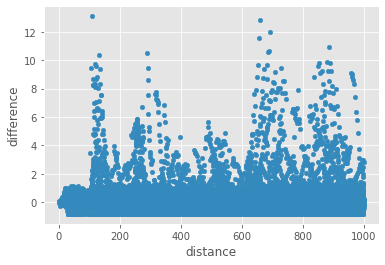

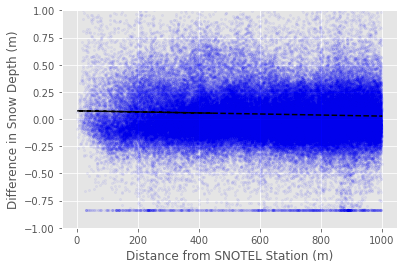

In [76]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

df_filtered.plot.scatter("distance", "difference")
#ax.set_yscale("log");



theta = np.polyfit(df_filtered['distance'], df_filtered['difference'], 1)
y_line = theta[1] + theta[0] * df_filtered['distance']

fig = plt.figure()
ax = plt.gca()
ax.scatter(df_filtered['distance'] , df_filtered['difference'], s = 5, alpha = .05, color = 'blue')
#ax.set_yscale('log')
#plt.plot(df_depths['distance'], y_line, 'r', color = 'black')

z = np.polyfit(df_filtered['distance'], df_filtered['difference'], 1)
p = np.poly1d(z)
plt.plot(df_filtered['distance'],p(df_filtered['distance']),"r--", color = 'black')
plt.ylim([-1, 1])
#plt.yscale('symlog')
ax.set_ylabel('Difference in Snow Depth (m)')
ax.set_xlabel('Distance from SNOTEL Station (m)')

#numpy.polyfit('distance', 'difference', degree = 1)

plt.savefig('line_plot.png')

## import matplotlib.pyplot as plt  
# calculate difference of depths in meters
station_depth =  station_data["SNOWDEPTH"].values[-1] / 25.4
df_depths["difference"] = station_depth - df_depths["depth"]

(array([1.228e+03, 3.400e+01, 5.500e+01, 3.700e+01, 4.000e+01, 2.200e+01,
        2.600e+01, 2.800e+01, 2.900e+01, 2.100e+01, 2.500e+01, 5.900e+01,
        5.500e+01, 6.900e+01, 4.900e+01, 5.700e+01, 4.400e+01, 6.400e+01,
        6.900e+01, 8.500e+01, 8.100e+01, 8.300e+01, 8.900e+01, 1.070e+02,
        1.290e+02, 1.270e+02, 1.430e+02, 1.720e+02, 2.110e+02, 2.170e+02,
        2.530e+02, 2.800e+02, 2.930e+02, 3.670e+02, 4.400e+02, 4.480e+02,
        5.680e+02, 6.460e+02, 7.650e+02, 8.610e+02, 1.081e+03, 1.244e+03,
        1.446e+03, 1.657e+03, 1.945e+03, 2.102e+03, 2.430e+03, 2.754e+03,
        3.129e+03, 3.592e+03, 3.894e+03, 4.254e+03, 4.516e+03, 4.818e+03,
        5.165e+03, 5.244e+03, 5.206e+03, 5.215e+03, 5.120e+03, 4.888e+03,
        4.599e+03, 4.394e+03, 4.194e+03, 4.009e+03, 3.664e+03, 3.431e+03,
        3.326e+03, 3.061e+03, 2.871e+03, 2.672e+03, 2.477e+03, 2.398e+03,
        2.333e+03, 2.171e+03, 2.003e+03, 1.934e+03, 1.812e+03, 1.694e+03,
        1.568e+03, 1.559e+03, 1.298e+0

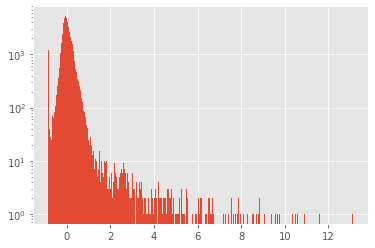

In [65]:
# plot the histogram of the differences of the data
plt.hist(df_filtered['difference'], log=True, bins=1000)

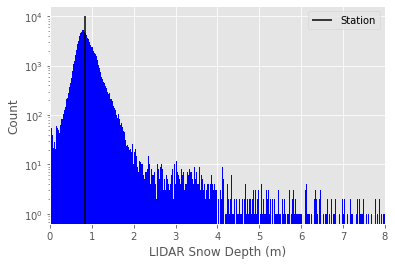

In [73]:
fig, ax = plt.subplots()
ax.hist(df_filtered['depth'], log=True, bins=1000, color = 'blue')
ax.vlines(station_depth, ymin=0, ymax=10000, color="black", label = 'Station')
ax.set_xlabel('LIDAR Snow Depth (m)')
ax.set_ylabel('Count')
ax.set_xlim([0,8])
ax.legend()
plt.savefig('histogram.png')


In [27]:
!pip install scikit-gstat
import skgstat as skg
from skgstat import Variogram, OrdinaryKriging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-gstat: filename=scikit_gstat-1.0.1-py3-none-any.whl size=703469 sha256=d8f683dbbf9690793c67e6f346841a72875c50fe93f5c998878ba05077900195
  Stored in directory: /home/jovyan/.cache/pip/wheels/e0/ef/11/b57bca83e1d9f1ae62eaf3d294264e05b2c7eb6872f3091d66
Successfully built scikit-gstat


In [28]:
%env SKG_SUPPRESS = true

env: SKG_SUPPRESS=true


In [30]:
V1 = Variogram(df_depths[['difference', 'y']].values, df_depth.z.values, normalize=False)
V1.plot(show=False);

KeyError: "['y'] not in index"